In [1]:
import datetime as dt
import utils
from sentinelsat import SentinelAPI
import json
import rasterio
import itertools

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.morphology import erosion, dilation, opening, closing, disk

from rasterio import plot
# import ee # Earth Engine
# ee.Initialize()
# ee.Authenticate()

In [ ]:
geojson_path = "data/var.geojson"
credentials_path = "secrets/sentinel_api_credentials.json"
wildfire_date = dt.date(2021, 8, 17)
observation_interval = 15
path = 'data/'
output_folder = 'output/'

In [ ]:
with open(credentials_path, 'r') as infile:
    credentials = json.load(infile)

api = SentinelAPI(
    credentials["username"],
    credentials["password"]
)

In [ ]:
before_image, after_image = utils.get_before_after_images(
    api=api, wildfire_date=wildfire_date, geojson_path=geojson_path,
    observation_interval=observation_interval, path=path,
    band1='B04', band2='B08', name='var', output_folder=output_folder,
    resolution=10, cloud_threshold=40
)

In [ ]:
# plot before_image and after_image side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(before_image)
ax[1].imshow(after_image)
plt.show()

In [ ]:
diff = before_image - after_image

plt.figure(figsize=(10, 10))
plt.imshow(diff)
plt.show()

In [ ]:
thresholded = utils.threshold_filter(diff, threshold=0.25)

plt.figure(figsize=(10, 10))
plt.imshow(diff)
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].imshow(before_image)
axs[0, 1].imshow(after_image)
axs[1, 0].imshow(diff)
axs[1, 1].imshow(thresholded)
plt.show()

Open tiff files

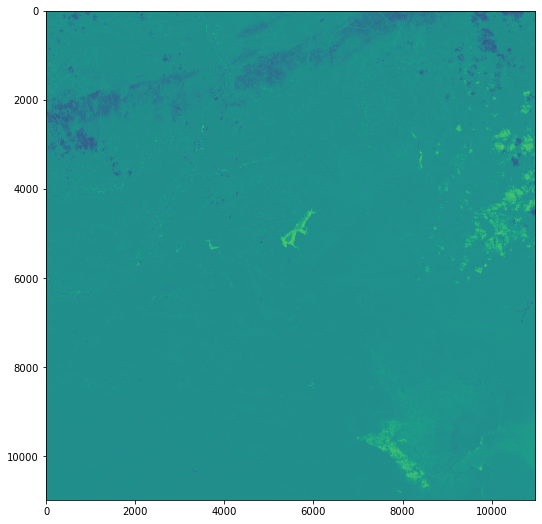

In [2]:
arr1 = rasterio.open('./output/before_var.tiff').read(1)
arr2 = rasterio.open('./output/after_var.tiff').read(1)
diff = arr1 - arr2

plt.figure(figsize=(16, 9))
plt.imshow(diff)
plt.show()

In [3]:
thresholded = utils.threshold_filter(diff, threshold=0.25)
# thresholded[thresholded > 0] = 1

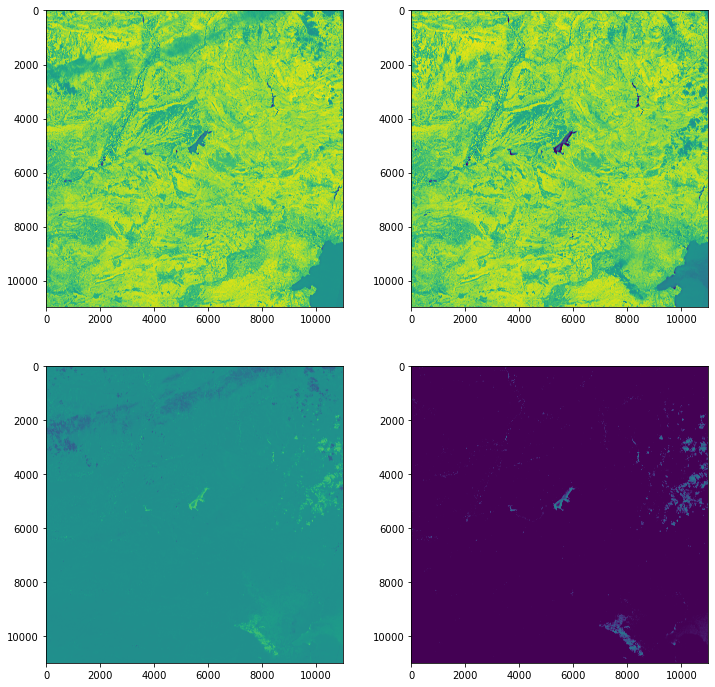

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].imshow(arr1)
axs[0, 1].imshow(arr2)
axs[1, 0].imshow(diff)
axs[1, 1].imshow(thresholded)
plt.show()

In [5]:
frag_count = 6
frag_size = int(diff.shape[0] / frag_count)
frag_dict = {}

for y, x in itertools.product(range(frag_count), range(frag_count)):
    frag_dict[(x, y)] = diff[y * frag_size: (y + 1) * frag_size,
        x * frag_size: (x + 1) * frag_size]

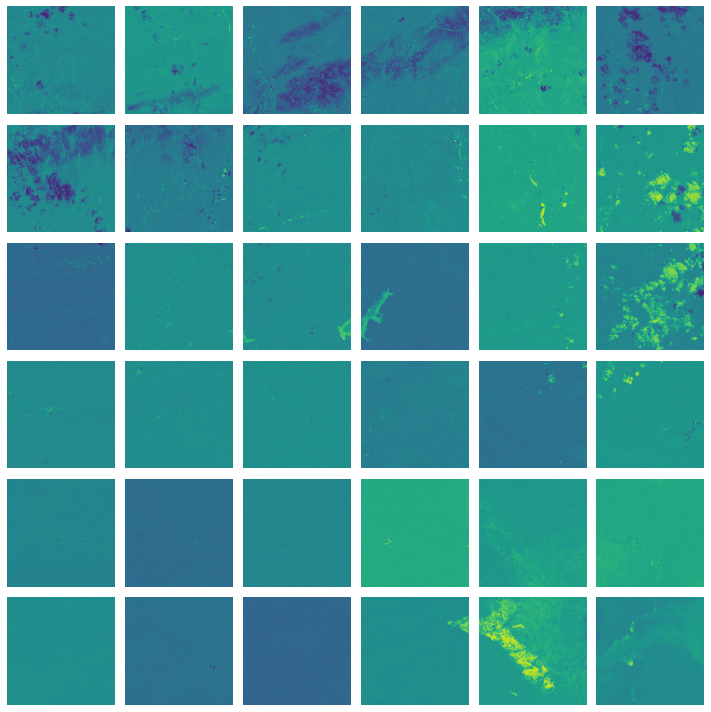

In [6]:
fig, axs = plt.subplots(frag_count, frag_count, figsize=(10, 10))
for y, x in itertools.product(range(frag_count), range(frag_count)):
    axs[y, x].imshow(frag_dict[(x, y)])
    axs[y, x].axis('off')
plt.tight_layout()
plt.show()

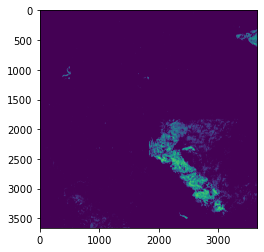

In [7]:
res = utils.merge_four_images([
    frag_dict[(3, 4)], frag_dict[(4, 4)], frag_dict[(3, 5)], frag_dict[(4, 5)]
])

res = utils.threshold_filter(res, threshold=0.21)
# res[res > 0] = 1

plt.imshow(res)
plt.show()

In [8]:
utils.calculate_area(res, diff) * 100

6916.9

True burnt area is around 7000 ha.

Morphology from `skimage`

In [9]:
def plot_comparison(original, filtered, filter_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered)
    ax2.set_title(filter_name)
    ax2.axis('off')

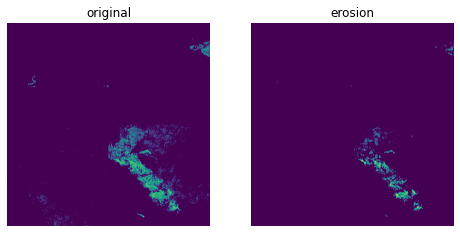

2034.77


In [10]:
footprint = disk(6)
eroded = erosion(res, footprint)
plot_comparison(res, eroded, 'erosion')
plt.show()

print(utils.calculate_area(eroded, diff) * 100)

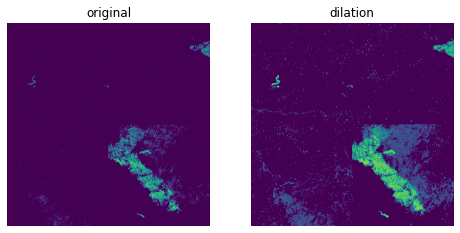

19494.69


In [11]:
dilated = dilation(res, footprint)
plot_comparison(res, dilated, 'dilation')
plt.show()

print(utils.calculate_area(dilated, diff) * 100)

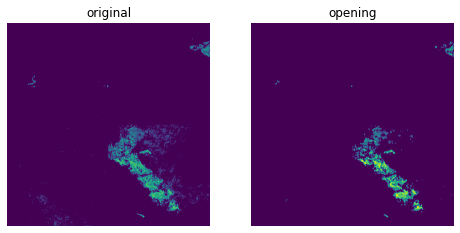

3900.5699999999997


In [12]:
opened = opening(res, footprint)
plot_comparison(res, opened, 'opening')
plt.show()

print(utils.calculate_area(opened, diff) * 100)

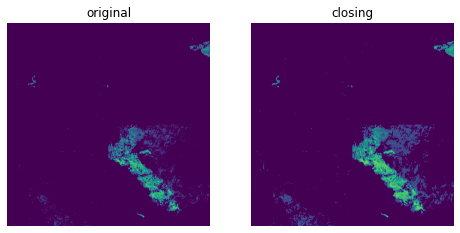

11027.37


In [13]:
closed = closing(res, footprint)
plot_comparison(res, closed, 'closing')
plt.show()

print(utils.calculate_area(closed, diff) * 100)

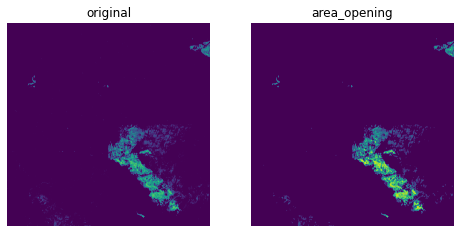

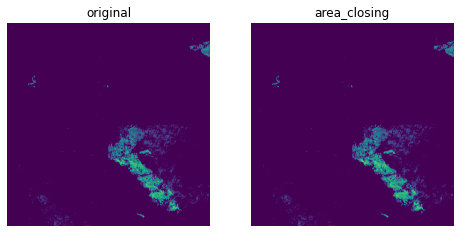

In [14]:
from skimage.morphology import area_closing, area_opening

plot_comparison(res, area_opening(res), 'area_opening')
plt.show()

plot_comparison(res, area_closing(res), 'area_closing')
plt.show()

---
Running the following cells is equivalent to calling `get_before_after_images` directly

In [ ]:
dates = (dt.date(2021, 8, 2), dt.date(2021, 8, 16))
images_df = utils.get_dataframe_between_dates(api, dates[0], dates[1], geojson_path)

In [ ]:
images_df = utils.minimize_dataframe(images_df)

In [ ]:
key_cols = ["cloudcoverpercentage", "vegetationpercentage",
            "waterpercentage", "size", "ingestiondate", "score"]
images_df[key_cols]

In [ ]:
uuid, title = utils.get_uuid_title(images_df)

In [ ]:
path = './data/'
utils.download_from_api(api, uuid, title, path)

In [ ]:
corr_matrix = images_df.corr()

plt.figure(figsize=(10, 10))
hm = sns.heatmap(corr_matrix, linewidths=1, linecolor='gray', cmap='coolwarm')
hm.set_yticklabels(hm.get_yticklabels(), fontsize=11)
hm.set_xticklabels(hm.get_xticklabels(), rotation=45, fontsize=11, ha='right')
plt.show()

In [ ]:
wildfire_date = dt.date(2021, 8, 17)
observation_interval = 15

In [ ]:
test1 = utils.get_image(api=api, wildfire_date=wildfire_date,
    observation_interval=observation_interval, when='before',
    geojson_path=geojson_path, path='data/',
    band1='B04', band2='B08', output_folder='output/', resolution=10)

In [ ]:
plt.figure(figsize=(16, 9))
plot.show(test1)
plt.show()

In [ ]:
test2 = utils.get_image(api=api, wildfire_date=wildfire_date,
    observation_interval=observation_interval, when='after',
    geojson_path=geojson_path, path='data/',
    band1='B04', band2='B08', output_folder='output/', resolution=10)

In [ ]:
plt.figure(figsize=(16, 9))
plot.show(test2)
plt.show()

In [ ]:
diff = test1 - test2

plt.figure(figsize=(16, 9))
plt.imshow(diff)
plt.show()

In [ ]:
diff = utils.threshold_filter(diff, 0.25)

plt.figure(figsize=(16, 9))
plt.imshow(diff)
plt.show()